# Xinyue Final Project - Netflix videos rating prediction


### Overview of Unsupervised Learning Problem

This project uses unsupervised model to predict ratings for videos on Netflix. The problem is, if we know some people have rated some movies, but haven't seen others, what rating will these people give to the unseen ones? Then the recommendation system can promote the movies with potential high ratings.

The reason why I choose this, is that I am a subscriber of Netflix, and this is a good chance for me to tackle some real-word ML problems. 

This dataset also contains publish-year as a feature, which may give me more insight.

Also, this project has much bigger size compared to our weekly assignment, so I will work on some interesting `data trimming/regularization` techniques.



### Data source

The dataset is provided by Netflix on kaggle: https://www.kaggle.com/datasets/rishitjavia/netflix-movie-rating-dataset/data
The data contains 2 csv files:
- Netflix_Dataset_Movie.csv: list of movies
- Netflix_Dataset_Rating.csv: list of ratings



I will include the following sections:
- 1. Exploratory Data Analysis (EDA)
- 2. Model Building and Training
  - I will use 2 unsupervised algos: `Matrix Decomposition` and `Collaborative Filtering`
- 3. Model Comparisons
- 4. Conclusions

In [41]:
#import important libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

#EDA and preprocessing
import re
from string import digits

#modeling
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import sklearn.metrics as metrics
import itertools
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from scipy.sparse import coo_matrix, csr_matrix
from scipy.spatial.distance import jaccard, cosine 



In [3]:
path_dir = '/kaggle/input/netflix-movie-rating-dataset/'
movie_path = path_dir + 'Netflix_Dataset_Movie.csv'
rating_path = path_dir + 'Netflix_Dataset_Rating.csv'
print(os.listdir(path_dir))

['Netflix_Dataset_Movie.csv', 'Netflix_Dataset_Rating.csv']


In [4]:
#import data
movies = pd.read_csv(movie_path)
ratings = pd.read_csv(rating_path)

## 1. Exploratory Analysis (EDA)



### 1.1 data size 
Let's first of all take a look at the data dimensions

In [8]:
movies

,Movie_ID,Year,Name
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004,Fidel Castro: American Experience
17767,17768,2000,Epoch
17768,17769,2003,The Company


In [47]:
movies.describe()

,Movie_ID,Year
count,17770.000000,17770.000000
mean,8885.500000,1990.235566
std,5129.901477,16.564501
min,1.000000,1915.000000
25%,4443.250000,1985.000000
50%,8885.500000,1997.000000
75%,13327.750000,2002.000000
max,17770.000000,2005.000000


In [48]:
movies['Movie_ID'].nunique()

17770

We can see we have 17770 movies, and all of the movie ids are unique, ranging from 1-17770. That means the `movie_id field is already cleaned`.

### Then let's take a look at the feature - `publish year`

As we can see below, we have 2 observations:
- All movie years have valid number
- The more recent, the number of movies are more

In [9]:
print(f"Number of movies with nan year: {np.isnan(movies['Year']).sum()}")
print(f"Number of movies with inf year: {np.isinf(movies['Year']).sum()}")
print(f"Number of movies with 0 year: {(movies['Year']==0).sum()}")

Number of movies with nan year: 0
Number of movies with inf year: 0
Number of movies with 0 year: 0


<ipython-input-50-0633d4e05948>:2: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


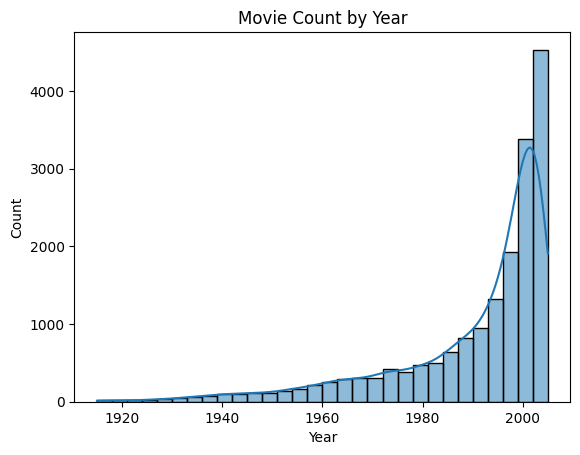

In [50]:
# Investigate the year distribution
with pd.option_context('mode.use_inf_as_na', True):
    sns.histplot(movies["Year"], bins=30, kde=True)  # Histogram with Kernel Density Estimation (KDE)
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.title("Movie Count by Year")
    plt.show()

In [51]:
ratings

,User_ID,Rating,Movie_ID
0,712664,5,3
1,1331154,4,3
2,2632461,3,3
3,44937,5,3
4,656399,4,3
...,...,...,...
17337453,520675,3,4496
17337454,1055714,5,4496
17337455,2643029,4,4496
17337456,1559566,3,4496


### Then, let's visualize the rating count

In [62]:
ratings["Rating"].value_counts().sort_index(ascending=True)

Rating
1     721356
2    1759281
3    5185650
4    5901368
5    3769803
Name: count, dtype: int64

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


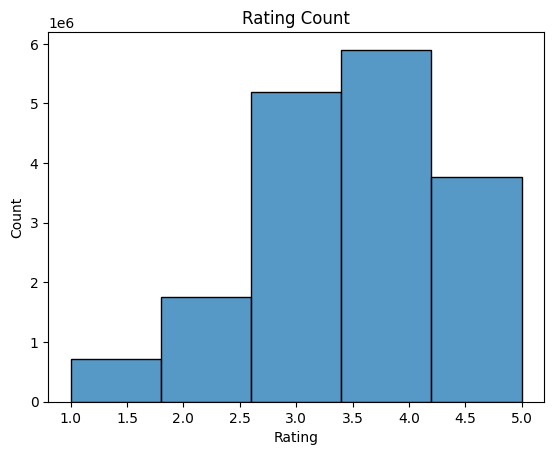

In [98]:
sns.histplot(ratings["Rating"], bins=5) 
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Rating Count")
plt.show()

We can see most of the ratings are in 3 and 4.

In [22]:
num_users = ratings["User_ID"].nunique()
num_users

143458

In [53]:
num_movies_rated = ratings["Movie_ID"].nunique()
num_movies_rated

1350

So out of the total 17770 movies, only 1350 have ratings. Then I will only work on those 1350 movies with rating.

As I investigate below, I have a few observations:
- The distribution of `movies with rating` and `all movies` are somehow similar: the more recent, the number is more.
- 2000 year is the peak for movies with rating, but the peak for all movies are around 2002-2005.

In [10]:
filtered_movie_ids = set(ratings["Movie_ID"].unique())
filtered_movies = movies[movies["Movie_ID"].isin(filtered_movie_ids)]
filtered_movies

,Movie_ID,Year,Name
2,3,1997,Character
7,8,2004,What the #$*! Do We Know!?
15,16,1996,Screamers
16,17,2005,7 Seconds
17,18,1994,Immortal Beloved
...,...,...,...
4487,4488,2000,Wonder Boys
4489,4490,2004,Ned Kelly
4491,4492,2004,Club Dread
4492,4493,2003,Ju-on: The Grudge


<ipython-input-55-b86c6e84ea74>:1: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


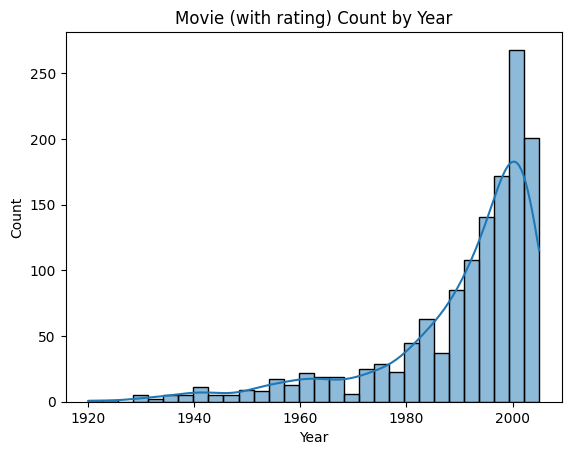

In [55]:
with pd.option_context('mode.use_inf_as_na', True):
    sns.histplot(filtered_movies["Year"], bins=30, kde=True)  # here we use filtered_movies
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.title("Movie (with rating) Count by Year")
    plt.show()

### Relationship research

Let's also investigate if the movie rating is correlated to the feature `publish year`

In [11]:
movie_avg_rating_total = ratings.groupby("Movie_ID")["Rating"].mean()

movie_avg_rating_total

Movie_ID
3       3.621391
8       3.136795
16      3.081843
17      2.909964
18      3.767597
          ...   
4488    3.540236
4490    3.161849
4492    2.652510
4493    3.164875
4496    3.765795
Name: Rating, Length: 1350, dtype: float64

In [12]:
# Sort the movies by year so later we can use "Year" as x-axis to plot
filtered_movies.loc[:, "avg_rating"] = filtered_movies["Movie_ID"].map(movie_avg_rating_total)
filtered_movies = filtered_movies.sort_values(by=['Year'])
filtered_movies

<ipython-input-12-af26f73f53a0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_movies.loc[:, "avg_rating"] = filtered_movies["Movie_ID"].map(movie_avg_rating_total)


,Movie_ID,Year,Name,avg_rating
2846,2847,1920,The Mark of Zorro,3.392012
4248,4249,1925,Battleship Potemkin,3.818465
3222,3223,1929,Nosferatu: Original Version,3.684463
906,907,1930,Animal Crackers,4.032348
3223,3224,1930,All Quiet on the Western Front,3.691203
...,...,...,...,...
1993,1994,2005,The L Word: Season 2,4.106113
731,732,2005,11:14,3.260153
1997,1998,2005,Saving Face,3.504111
3713,3714,2005,The Ballad of Jack and Rose,2.918718


In [58]:
year_avg_rating = filtered_movies.groupby("Year")["avg_rating"].mean()
year_75pct_rating = filtered_movies.groupby("Year")["avg_rating"].quantile(0.75)
year_25pct_rating = filtered_movies.groupby("Year")["avg_rating"].quantile(0.25)

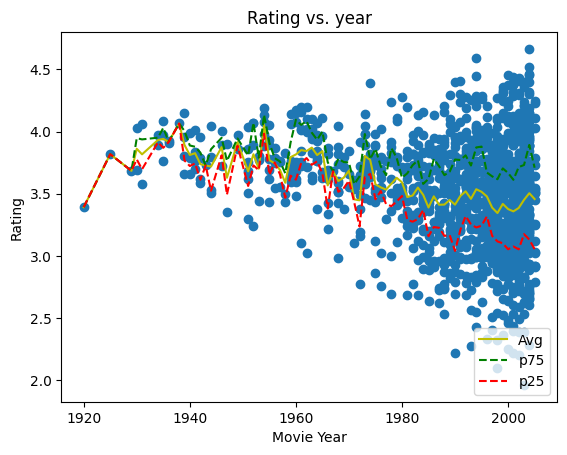

In [59]:
fig, ax = plt.subplots()


ax.scatter(filtered_movies["Year"], filtered_movies["avg_rating"])
ax.plot(sorted(filtered_movies["Year"].unique()), year_avg_rating, 'y-', label='Avg')
ax.plot(sorted(filtered_movies["Year"].unique()), year_75pct_rating, 'g--', label='p75')
ax.plot(sorted(filtered_movies["Year"].unique()), year_25pct_rating, 'r--', label='p25')
ax.set_xlabel('Movie Year')
ax.set_ylabel('Rating')
ax.set_title('Rating vs. year')

leg = ax.legend(loc="lower right")
plt.show()

As we can see the rating-year plot above, a few observations:
- The more recent, the more ratings in general.
  - Likely due to more and more movies are produced recently.
- The rating-year plot has a slight downwards trend, but the trend is not very significant.
- The yearly-avg rating (yellow) fluctuates between 3.5 - 4.0
- The p75 rating (top 25%, green) looks flat, meaning that the `top` movie ratings seem to be stable across years.
- The p25 rating (bottom 25%, red) looks downwards, meaning that the `bad` movies have rating worse and worse across years.

### 1.2 training-test split
Let's do training-test split beforehand now.
Reason:
- the model will not be able to see the unseen test set in any way
- This kaggle doesn't have a native test dataset, so I need to split raw data to have a test set.

In [13]:
rating_train, rating_test = train_test_split(ratings, test_size=0.3, random_state=42)

In [14]:
rating_train

,User_ID,Rating,Movie_ID
16374600,1337166,4,4302
10003746,1720130,2,2660
1077610,930935,5,311
9564862,2016928,3,2499
10667849,1686257,4,2862
...,...,...,...
9628519,717338,5,2533
14586186,2259144,1,3858
2234489,187251,4,571
13315092,1236413,4,3526


Let's check if in the split training dataset, all movies or users have at least 1 rating. Otherwise, we will have 0 info onto that user or movie.

In [15]:
rating_train["Movie_ID"].nunique()

1350

In [16]:
rating_train["User_ID"].nunique()

143458

We can see all movies and all users have at least 1 rating, which will make the things easier.

In [17]:
# the matrix is pretty sparse: only 6.27% entries are non-zero
rating_matrix_entry_count = 1350 * 143458
training_rating_count = rating_train.shape[0]
print(f"percentage of rating matrix filled: {round(training_rating_count/rating_matrix_entry_count*100, 2)}%")

percentage of rating matrix filled: 6.27%


### 1.3 data cleanup

Eventually we want to get a rating matrix of size (# of users, # of movies). However, we have quite a lot (143458) of user id here, which will make the rating matrix too large (143458-by-1350). I don't have a top-tier computer as well. 

To make our life easier, I will do some data trimming to reduce the number of user, which will help a lot in reducing rating matrix size. 

However, since I propose to reduce the number of users, but in case later the rating from those users are needed to predict, I need to save the average ratings for those users as a proxy value. 

In [18]:
# Compute average rating per user
avg_rating_per_user = rating_train.groupby("User_ID")["Rating"].mean()

# Compute average rating per movie
avg_rating_per_movie = rating_train.groupby("Movie_ID")["Rating"].mean()

In [19]:
avg_rating_per_movie

Movie_ID
3       3.628229
8       3.132382
16      3.061728
17      2.919255
18      3.768400
          ...   
4488    3.540255
4490    3.155894
4492    2.661694
4493    3.168769
4496    3.769636
Name: Rating, Length: 1350, dtype: float64

In [20]:
user_2_rating_count = rating_train.groupby(['User_ID'])["Movie_ID"].count() 
# sort values ascending will help to eliminate least important users
user_2_rating_count = user_2_rating_count.sort_values(ascending=True)
user_2_rating_count

User_ID
1768970      2
964881       5
949045       7
1445218      7
1009839      8
          ... 
1664010    892
2439493    916
2118461    922
305344     928
387418     934
Name: Movie_ID, Length: 143458, dtype: int64

<ipython-input-68-b0822fb46aa6>:1: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


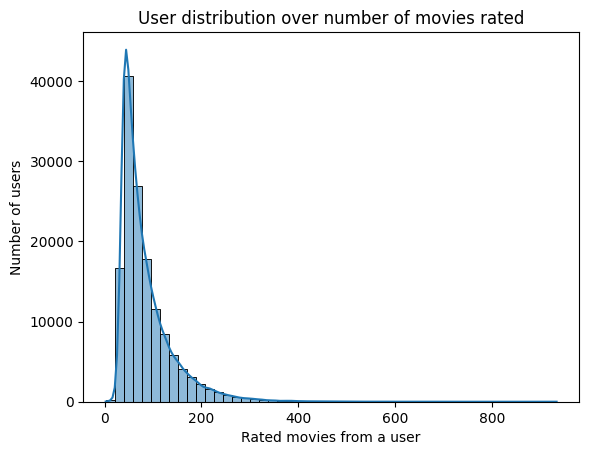

In [68]:
with pd.option_context('mode.use_inf_as_na', True):
    sns.histplot(user_2_rating_count.values, bins=50, kde=True)  # here we use filtered_movies
    plt.xlabel("Rated movies from a user")
    plt.ylabel("Number of users")
    plt.title("User distribution over number of movies rated")
    plt.show()

Not surprising, most of the users rate a small number of movies, and a little portion of users rate a lot of movies. 

As I mentioned before, I want to remove the users with least number of ratings for computational performance.

In [69]:
delete_ratings = 0
delete_users = 0
percentage = 0.01
MAX_DELETE = 0.5

rating_pct, user_pct = [], []

# DRY RUN
for index, value in user_2_rating_count.items():
    #print(f"User_ID : {index}, Rated movie count : {value}")
    delete_users += 1
    delete_ratings += value
    if delete_ratings >= percentage * training_rating_count:
        delete_user_pct = delete_users/num_users
        rating_pct.append(percentage*100)
        user_pct.append(delete_user_pct*100)
        print(f"Delete {round(percentage*100,0)}% ratings will remove {delete_users} users ({round(delete_user_pct*100,1)}% of users)")
        percentage += 0.01
        if percentage> MAX_DELETE:
            break


Delete 1.0% ratings will remove 4101 users (2.9% of users)
Delete 2.0% ratings will remove 7631 users (5.3% of users)
Delete 3.0% ratings will remove 10965 users (7.6% of users)
Delete 4.0% ratings will remove 14183 users (9.9% of users)
Delete 5.0% ratings will remove 17286 users (12.0% of users)
Delete 6.0% ratings will remove 20301 users (14.2% of users)
Delete 7.0% ratings will remove 23236 users (16.2% of users)
Delete 8.0% ratings will remove 26097 users (18.2% of users)
Delete 9.0% ratings will remove 28887 users (20.1% of users)
Delete 10.0% ratings will remove 31610 users (22.0% of users)
Delete 11.0% ratings will remove 34269 users (23.9% of users)
Delete 12.0% ratings will remove 36866 users (25.7% of users)
Delete 13.0% ratings will remove 39405 users (27.5% of users)
Delete 14.0% ratings will remove 41886 users (29.2% of users)
Delete 15.0% ratings will remove 44307 users (30.9% of users)
Delete 16.0% ratings will remove 46676 users (32.5% of users)
Delete 17.0% ratings wi

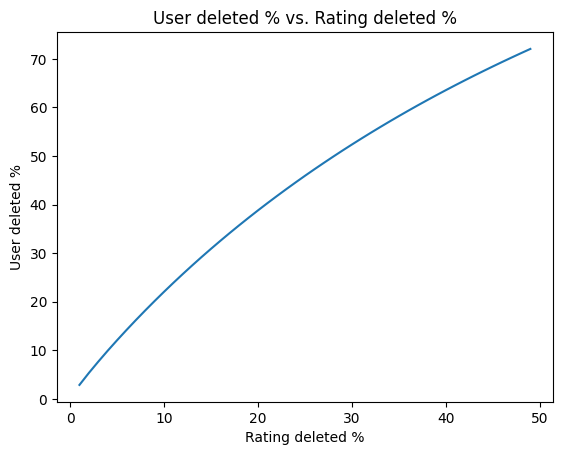

In [70]:
plt.plot(rating_pct, user_pct)
plt.xlabel('Rating deleted %')
plt.ylabel('User deleted %')
plt.title('User deleted % vs. Rating deleted %')
plt.show()

As we can see, there is no obvious `turning elbow` for the user delete % vs. Rating deleted % graph. But we do see the graph goes flat when number goes higher. Meaning that, at very beginning, deleting small amount of ratings will remove large amount of users (which is good), but the benefit diminishes. 

Therefore, let me remove `20% of rating` data, and then the number of users can be reduced by 38.8% (143458 - 55659 = 87799).

In [23]:
TARGET_RATING_DELETE = 0.20

removed_user_id = set()
delete_ratings = 0

# user_2_rating_count already sorted
for index, value in user_2_rating_count.items():
    removed_user_id.add(index)
    #print(f"User_ID : {index}, Rated movie count : {value}")
    delete_ratings += value
    if delete_ratings >= TARGET_RATING_DELETE * training_rating_count:
        delete_users = len(removed_user_id)
        delete_user_pct = delete_users/num_users
        print(f"Deleted {round(TARGET_RATING_DELETE*100,0)}% ratings, and removed {delete_users} users ({round(delete_user_pct*100,1)}% of users)")
        break

Deleted 20.0% ratings, and removed 55659 users (38.8% of users)


In [24]:
# delete 20% ratings
core_ratings = rating_train[~rating_train["User_ID"].isin(removed_user_id)]
core_ratings

,User_ID,Rating,Movie_ID
16374600,1337166,4,4302
10003746,1720130,2,2660
1077610,930935,5,311
9564862,2016928,3,2499
10667849,1686257,4,2862
...,...,...,...
9628519,717338,5,2533
14586186,2259144,1,3858
2234489,187251,4,571
13315092,1236413,4,3526


### 1.4 rating matrix construction

I will use the `9708972` rating data points above, to construct a 87799 (users) by 1350 (movies) rating matrix.

Before I build rating matrix, I need to transform the data (userId and movieId), just like what we did in week3 assignment. The reason is that, the matrix row / column numbers are `0-indexed`, but the given user id and movie id are not. 

In [25]:
# construct user id index for not-removed users
saved_users = sorted([user_id for user_id in user_2_rating_count.index if user_id not in removed_user_id])
usr_2_idx = {user_id: idx for idx, user_id in enumerate(saved_users)}
idx_2_usr = {idx: user_id for idx, user_id in enumerate(saved_users)}

In [26]:
# construct movie index
movie_2_idx = {movie_id: idx for idx, movie_id in enumerate(list(filtered_movie_ids))}
idx_2_movie = {idx: movie_id for idx, movie_id in enumerate(list(filtered_movie_ids))}

In [27]:
# construct rating matrix

idx_user = [usr_2_idx[user_id] for user_id in core_ratings["User_ID"].values]
idx_movie = [movie_2_idx[movie_id] for movie_id in core_ratings["Movie_ID"].values]
rating_values = core_ratings["Rating"].values

rating_matrix = coo_matrix((rating_values, (idx_user, idx_movie)), shape=(len(usr_2_idx), len(movie_2_idx)))

In [28]:
rating_matrix = np.array(rating_matrix.toarray()).astype(float)

# 2. Model Building and Training 

One thing I would like to highlight is that, I reduced user number by ~40% in steps above. Given a (userid, movieid) pair, if the userId is deleted previously, then the prediction rating, will be the simple avg from avg_rating_per_user and avg_rating_per_movie

### 2.1 Collaborative filtering

First let me try Collaborative filtering, since we have plenty of rating data (9.7M). Since the rating value is numerical instead of categorical, I would like to use `cosine` distance to evaluate movie-to-movie similarity.

In the Collaborative filtering, the `features` for prediction is not very obvious: 
- the features represent latent factors that capture the relationship between users and movies, which are not explicitly available (e.g., "action movie preference," "comedy lover").
  - Those features need to be learned through similarity matrix, or matrix decomposition.
- one other thing to notice is that, the more number of users, the more rows there will be in rating matrix, causing the model overly complicated.
  - Thus, reducing insignificant users (like 20% above), can be a potential way to apply **`regularization`**.

### 2.1.1 base model training testing

#### step 1: get 0-indexed user average rating

In [29]:
# step 1: get 0-indexed user average rating

uidx_rating = [(usr_2_idx[user_id], r) for user_id, r in avg_rating_per_user.items() if user_id in usr_2_idx]
uidx_rating.sort() # sort by mapped user_idx
uidx_rating = np.array([r for _, r in uidx_rating]).reshape((-1,1))
print(f"Mapped user average rating: matrix shape={uidx_rating.shape}")
uidx_rating

Mapped user average rating: matrix shape=(87799, 1)


array([[3.28571429],
       [4.04225352],
       [3.52142857],
       ...,
       [3.32824427],
       [3.74647887],
       [4.13114754]])

In [30]:
# this is just for sanity check purpose: 
# use a different method to calculate user average rating, to make sure everything is correct
uidx_rating_2 = np.array([avg_rating_per_user.get(user_id) for user_id in saved_users]).reshape((-1,1))
assert uidx_rating.shape == uidx_rating_2.shape
residual = uidx_rating-uidx_rating_2
assert abs(np.sum(residual**2))<1e-10, "user average rating calculation may be wrong"

#### step 2: subtract user_avg_rating from rating matrix

In [31]:
# step 2: subtract user_avg_rating from rating matrix

X = rating_matrix.copy()  # (#users, #movies)
X[X==0] = np.nan

user_avg = uidx_rating.copy()
X = X - user_avg
#print(f"X.shape={X.shape}, X={X}")
X[np.isnan(X)] = 0


In [32]:
# sanity check: after subtracting user average rating, the mean of each row should be 0
row_sums = X.sum(axis=1)
assert row_sums.shape[0] == len(saved_users), "number of saved users should match"
assert np.sum(row_sums**2) < 1e-10

#### Step 3: Normalize the matrix to unit length (column-wise)

In [33]:
# Step 3: Normalize the matrix to unit length (column-wise)
X_norm = np.linalg.norm(X, axis=0)  # Compute L2 norm of each column
# for each column, if L2 norm==0, then it's 0 vector, just assign any norm
X_norm[X_norm==0]=1
X_normalized = X / X_norm  # Normalize columns of X


#### Step 4: Compute the cosine similarity between each pair of columns

In [34]:
# Step 4: Compute the cosine similarity between each pair of columns
cosine_sim = np.dot(X_normalized.T, X_normalized)  # Result is a n-by-n matrix, -1 to 1
cosine_sim = cosine_sim*0.5 + 0.5 # convert to 0 to 1
cosine_sim[np.diag_indices_from(cosine_sim)] = 1 # (self,self) similarity is always 1

In [35]:
# sanity check: there is no nan in the similarity matrix
assert np.sum(np.isnan(cosine_sim)) == 0

In [36]:
def rmse(yt,yp):
    return np.sqrt(((yt-yp)**2).mean())

def predict_from_sim(user_id, movie_id, sim, rating_matrix, usr_2_idx=usr_2_idx, movie_2_idx=movie_2_idx):
    """
    Predict a user rating on a movie given userID and movieID
    """
    if user_id not in usr_2_idx:
        # case 1:
        # this user is removed before due to lack of rating,
        # so this user is not modeled by rating matrix.
        # we should use avg of user_rating and movie_rating
        u_avg_rating = avg_rating_per_user.get(user_id)
        m_avg_rating = avg_rating_per_movie.get(movie_id)
        return (u_avg_rating+m_avg_rating)/2
    else:
        # case 2:
        # this user is NOT removed, and modeled by rating matrix
        uidx = usr_2_idx[user_id]
        midx = movie_2_idx[movie_id]
        
        u_ratings = rating_matrix[uidx, :]
        if u_ratings[midx] > 0:
            return u_ratings[midx]
        similarity = sim[midx, :]
                
        mask = u_ratings > 0
    
        # Compute product sum and similarity sum
        product_sum = np.sum(u_ratings[mask] * similarity[mask])
        sim_sum = np.sum(similarity[mask])
        return product_sum/sim_sum


#### Step 5: Time to do rating prediction!

In [37]:
# sanity check 1: user id saved (NOT deleted), should use rating matrix to predict
test_user_id = 6
test_movie_id = 4492
usr_avg_r = avg_rating_per_user.get(test_user_id)
mov_avg_r = avg_rating_per_movie.get(test_movie_id)
predict_r = predict_from_sim(user_id=test_user_id, movie_id=test_movie_id, sim=cosine_sim, rating_matrix=rating_matrix)
print(f"usr_avg_r={usr_avg_r}, mov_avg_r={mov_avg_r}, (usr_avg_r+mov_avg_r)/2 = {(usr_avg_r+mov_avg_r)/2}, "
    f"predict_r={predict_r}")

usr_avg_r=3.2857142857142856, mov_avg_r=2.6616943966341555, (usr_avg_r+mov_avg_r)/2 = 2.9737043411742206, predict_r=3.279879642583792


In [38]:
# sanity check 2: user_id deleted, should use average of user rating and movie rating
test_user_id = 933
test_movie_id = 4492
usr_avg_r = avg_rating_per_user.get(test_user_id)
mov_avg_r = avg_rating_per_movie.get(test_movie_id)
predict_r = predict_from_sim(user_id=test_user_id, movie_id=test_movie_id, sim=cosine_sim, rating_matrix=rating_matrix)
print(f"usr_avg_r={usr_avg_r}, mov_avg_r={mov_avg_r}, (usr_avg_r+mov_avg_r)/2 = {(usr_avg_r+mov_avg_r)/2}, "
    f"predict_r={predict_r}")

usr_avg_r=3.5, mov_avg_r=2.6616943966341555, (usr_avg_r+mov_avg_r)/2 = 3.0808471983170778, predict_r=3.0808471983170778


In [39]:
# accuracy on training dataset
true_rating_train = rating_train["Rating"]
zipped_input_pairs = np.stack((rating_train["User_ID"], rating_train["Movie_ID"]), axis=-1)
pred_rating_train = np.array([predict_from_sim(user_id, movie_id, cosine_sim, rating_matrix) for user_id, movie_id in zipped_input_pairs])

In [40]:
rmse_train= rmse(np.array(true_rating_train), np.array(pred_rating_train))
rmse_train

0.4259265147052411

This is a quite good estimate! Compared with our week3 assignment, where the RMSE values are around above 0.95 in 1-5 scale, this RMSE of 0.426 is pretty accurate.

In [69]:
# confusion matrix
# note: confusion matrix can only handle categorical data, so I need to convert float number to int.

pred_rating_train_int = np.vectorize(round)(pred_rating_train)
cm = confusion_matrix(y_true=true_rating_train, y_pred=pred_rating_train_int)

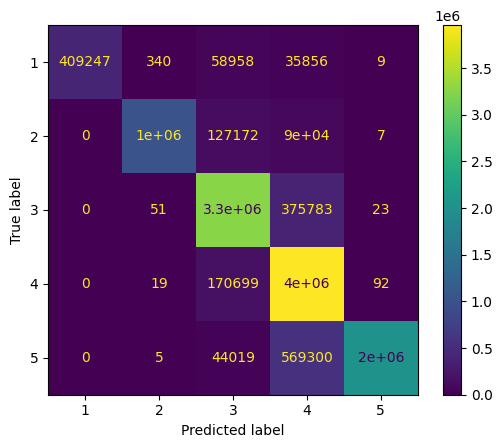

In [71]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=[1,2,3,4,5])
cm_display.plot()
plt.show()

#### Then let's work on test set

In [74]:
# accuracy on test dataset
true_rating_test = rating_test["Rating"]
zipped_input_pairs = np.stack((rating_test["User_ID"], rating_test["Movie_ID"]), axis=-1)
pred_rating_test = np.array([predict_from_sim(user_id, movie_id, cosine_sim, rating_matrix) for user_id, movie_id in zipped_input_pairs])

In [75]:
rmse_test= rmse(np.array(true_rating_test), np.array(pred_rating_test))
rmse_test

0.9727047801887826

The RMSE on test dataset is worse (0.973) compared to training RMSE (0.426). Then I am suspecting my model might be overfitting, and not robust enough.

In [76]:
# confusion matrix
# note: confusion matrix can only handle categorical data, so I need to convert float number to int.

pred_rating_test_int = np.vectorize(round)(pred_rating_test)
cm = confusion_matrix(y_true=true_rating_test, y_pred=pred_rating_test_int)

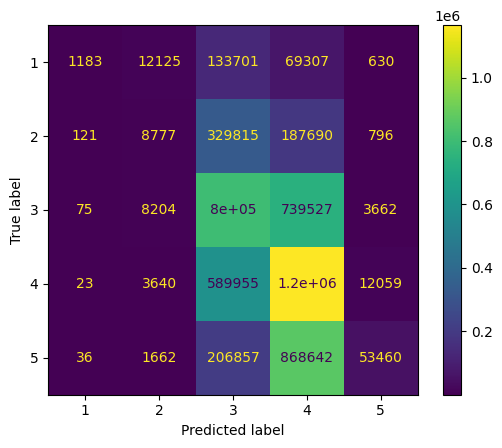

In [77]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=[1,2,3,4,5])
cm_display.plot()
plt.show()

The prediction on test dataset is highly biased towards 3 and 4:
- Many 1,2,5 scores, are incorrectly predicted to 3 and 4 scores.

### 2.1.2 hyper params tune - regularization (percentage of ratings deletion)

One possible explanation for the better accuracy, is that I am using more rating data, and the rating matrix is not too sparse (`percentage of rating matrix filled: 6.27%`). 
- whereas in our week3 assignment, the percentage of rating matrix filled is `2.99%`

Is my model very sensitive to training data count? What if I delete more data, will my model still be robust?
- Applying more data entries, especially more `user counts`, is essentially `adding more features`, which may cause overfitting.
- In my base model above, I delete 20% rating data for sake of computational efficiency. Now I will test to delete more, to test model robustness.

In [139]:
# Those functions below are almost the same as before, but more compact:
# I don't need step by step investigation here as the base model.
def rating_deletion(target_rating_delete):
    removed_user_id = set()
    delete_ratings = 0
    
    # user_2_rating_count already sorted
    for index, value in user_2_rating_count.items():
        removed_user_id.add(index)
        delete_ratings += value
        if delete_ratings >= target_rating_delete * training_rating_count:
            delete_users = len(removed_user_id)
            delete_user_pct = delete_users/num_users
            print(f"Deleted {round(target_rating_delete*100,0)}% ratings, and removed {delete_users} users ({round(delete_user_pct*100,1)}% of users)")
            break
    return removed_user_id

def build_rating_sim(removed_user_id):
    
    core_ratings = rating_train[~rating_train["User_ID"].isin(removed_user_id)]
    
    saved_users = sorted([user_id for user_id in user_2_rating_count.index if user_id not in removed_user_id])
    usr_2_idx = {user_id: idx for idx, user_id in enumerate(saved_users)}
    idx_2_usr = {idx: user_id for idx, user_id in enumerate(saved_users)}
    movie_2_idx = {movie_id: idx for idx, movie_id in enumerate(list(filtered_movie_ids))}
    idx_2_movie = {idx: movie_id for idx, movie_id in enumerate(list(filtered_movie_ids))}
    
    idx_user = [usr_2_idx[user_id] for user_id in core_ratings["User_ID"].values]
    idx_movie = [movie_2_idx[movie_id] for movie_id in core_ratings["Movie_ID"].values]
    rating_values = core_ratings["Rating"].values
    
    rating_matrix = coo_matrix((rating_values, (idx_user, idx_movie)), shape=(len(usr_2_idx), len(movie_2_idx)))
    rating_matrix = np.array(rating_matrix.toarray()).astype(float)

    uidx_rating = np.array([avg_rating_per_user.get(user_id) for user_id in saved_users]).reshape((-1,1))
    X = rating_matrix.copy()  # (#users, #movies)
    X[X==0] = np.nan
    
    user_avg = uidx_rating.copy()
    X = X - user_avg
    #print(f"X.shape={X.shape}, X={X}")
    X[np.isnan(X)] = 0
    row_sums = X.sum(axis=1)
    assert row_sums.shape[0] == len(saved_users), "number of saved users should match"
    assert np.sum(row_sums**2) < 1e-10
    
    X_norm = np.linalg.norm(X, axis=0)  # Compute L2 norm of each column
    # for each column, if L2 norm==0, then it's 0 vector, just assign any norm
    X_norm[X_norm==0]=1
    X_normalized = X / X_norm  # Normalize columns of X
    cosine_sim = np.dot(X_normalized.T, X_normalized)  # Result is a n-by-n matrix, -1 to 1
    cosine_sim = cosine_sim*0.5 + 0.5 # convert to 0 to 1
    cosine_sim[np.diag_indices_from(cosine_sim)] = 1 # (self,self) similarity is always 1
    return rating_matrix, cosine_sim, usr_2_idx, movie_2_idx

def eval_rmse(raw_df, rating_matrix, sim, usr_2_idx, movie_2_idx):
    true_rating = raw_df["Rating"]
    zipped_input_pairs = np.stack((raw_df["User_ID"], raw_df["Movie_ID"]), axis=-1)
    pred_rating = np.array([predict_from_sim(
        user_id, movie_id, sim, rating_matrix, usr_2_idx=usr_2_idx, movie_2_idx=movie_2_idx) 
                            for user_id, movie_id in zipped_input_pairs])
    rmse_train= rmse(np.array(true_rating), np.array(pred_rating))
    return rmse_train

In [6]:
TARGET_RATING_DELETE = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

In [155]:

train_rmse_list = []
test_rmse_list = []
for target_rating_delete in TARGET_RATING_DELETE:
    it_removed_user_id = rating_deletion(target_rating_delete)
    it_rating_mat, it_sim, it_usr_2_idx, it_movie_2_idx = build_rating_sim(it_removed_user_id)
    it_rmse_train = eval_rmse(rating_train, it_rating_mat, it_sim, it_usr_2_idx, it_movie_2_idx)
    it_rmse_test = eval_rmse(rating_test, it_rating_mat, it_sim, it_usr_2_idx, it_movie_2_idx)
    print(f"If delete {round(target_rating_delete*100, 2)}% data, rmse_train={it_rmse_train}, rmse_test={it_rmse_test}")
    train_rmse_list.append(it_rmse_train)
    test_rmse_list.append(it_rmse_test)

Deleted 5.0% ratings, and removed 17286 users (12.0% of users)
If delete 5.0% data, rmse_train=0.21504251135290967, rmse_test=0.9779087032866152
Deleted 10.0% ratings, and removed 31610 users (22.0% of users)
If delete 10.0% data, rmse_train=0.3027791992817632, rmse_test=0.9760684911687932
Deleted 20.0% ratings, and removed 55659 users (38.8% of users)
If delete 20.0% data, rmse_train=0.4259265147052411, rmse_test=0.9727047801887826
Deleted 30.0% ratings, and removed 75123 users (52.4% of users)
If delete 30.0% data, rmse_train=0.5204205619680803, rmse_test=0.9693225690196828
Deleted 40.0% ratings, and removed 91188 users (63.6% of users)
If delete 40.0% data, rmse_train=0.5994455000203325, rmse_test=0.9661189300389919
Deleted 50.0% ratings, and removed 104617 users (72.9% of users)
If delete 50.0% data, rmse_train=0.6686250005189642, rmse_test=0.9630107562976431
Deleted 60.0% ratings, and removed 115906 users (80.8% of users)
If delete 60.0% data, rmse_train=0.7311238830091864, rmse_t

Deleted 5.0% ratings, and removed 17286 users (12.0% of users)
If delete 5.0% data, rmse_train=0.21504251135290967, rmse_test=0.9779087032866152

Deleted 10.0% ratings, and removed 31610 users (22.0% of users)
If delete 10.0% data, rmse_train=0.3027791992817632, rmse_test=0.9760684911687932

Deleted 20.0% ratings, and removed 55659 users (38.8% of users)
If delete 20.0% data, rmse_train=0.4259265147052411, rmse_test=0.9727047801887826

Deleted 30.0% ratings, and removed 75123 users (52.4% of users)
If delete 30.0% data, rmse_train=0.5204205619680803, rmse_test=0.9693225690196828

Deleted 40.0% ratings, and removed 91188 users (63.6% of users)
If delete 40.0% data, rmse_train=0.5994455000203325, rmse_test=0.9661189300389919

Deleted 50.0% ratings, and removed 104617 users (72.9% of users)
If delete 50.0% data, rmse_train=0.6686250005189642, rmse_test=0.9630107562976431

Deleted 60.0% ratings, and removed 115906 users (80.8% of users)
If delete 60.0% data, rmse_train=0.7311238830091864, rmse_test=0.9598508793114201

Deleted 70.0% ratings, and removed 125342 users (87.4% of users)
If delete 70.0% data, rmse_train=0.7889651243897992, rmse_test=0.9568615263494854

Deleted 80.0% ratings, and removed 133106 users (92.8% of users)
If delete 80.0% data, rmse_train=0.8427037151805434, rmse_test=0.9538676399309384

Deleted 90.0% ratings, and removed 139276 users (97.1% of users)
If delete 90.0% data, rmse_train=0.8934855930454532, rmse_test=0.9510692343803511

Deleted 95.0% ratings, and removed 141710 users (98.8% of users)
If delete 95.0% data, rmse_train=0.9179611178797172, rmse_test=0.9498232559834812

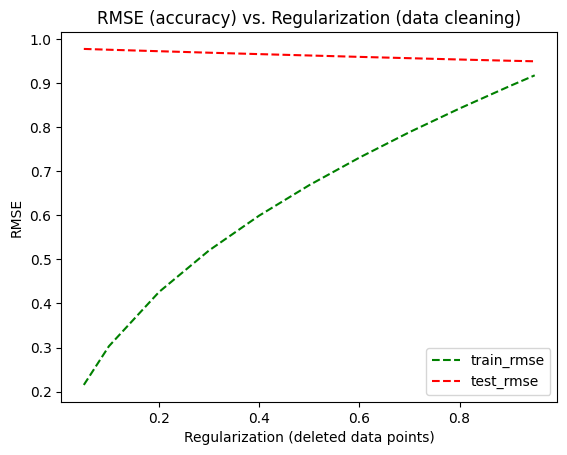

In [7]:
# those values are from the logs above
train_rmse_list = [0.21504251135290967, 0.3027791992817632, 0.4259265147052411, 0.5204205619680803,
                  0.5994455000203325, 0.6686250005189642, 0.7311238830091864, 0.7889651243897992,
                  0.8427037151805434, 0.8934855930454532, 0.9179611178797172]
test_rmse_list = [0.9779087032866152, 0.9760684911687932, 0.9727047801887826, 0.9693225690196828, 
                 0.9661189300389919, 0.9630107562976431, 0.9598508793114201, 0.9568615263494854,
                 0.9538676399309384, 0.9510692343803511, 0.9498232559834812]

fig, ax = plt.subplots()

ax.plot(TARGET_RATING_DELETE, train_rmse_list, 'g--', label='train_rmse')
ax.plot(TARGET_RATING_DELETE, test_rmse_list, 'r--', label='test_rmse')
ax.set_xlabel('Regularization (deleted data points)')
ax.set_ylabel('RMSE')
ax.set_title('RMSE (accuracy) vs. Regularization (data cleaning)')

leg = ax.legend(loc="lower right")
plt.show()

As we can see above, data deletion, as a way to apply regularization, can have an effect on RMSE on train/test set.
- The less data deletion, the less regularization we applied:
  -  the model is more accurate on training set, but worse on testing set, indicating overfitting.
- The opposite is true: the more regularization we applied:
  -  the model is less accurate on training set, but slightly better on testing test. 

## 2.2 Matrix Decomposition



### 2.2.1 base model build

For the sake of convenience, I will use the `20% rating-data reduction` as conducted above, as the starting point for this matrix decomposition.

#### Step 1: Impute the 0-value in rating matrix with user average

The reason for this imputation is that, if we don't do it, then the 0-valued rating will be mis-interpreted as `user rates 0 star`, instead of `user has not rated`. 

Therefore, I need to pre-fill the 0-values with some reasonable values. The most reasonable ones, are the user's average rating.

In [78]:
### step 1: get user average
ratings_imputed = rating_matrix.copy()
ratings_imputed[ratings_imputed==0] = np.nan
user_means = np.nanmean(ratings_imputed, axis=1, keepdims=True)

In [79]:
# sanity check
print(f"user_means.shape={user_means.shape}")
print(f"the NaN count within user_means: {np.isnan(user_means.reshape(-1)).sum()}")

user_means.shape=(87799, 1)
the NaN count within user_means: 0


We can see there is no NaN in user_means, and user_means has the correct number of entries (87799, which is after 20% reduction)

In [80]:
ratings_imputed = np.where(np.isnan(ratings_imputed), user_means, ratings_imputed)
# glance at imputed ratings
ratings_imputed[:10, :10]

array([[3.28571429, 3.28571429, 3.28571429, 3.28571429, 3.28571429,
        3.28571429, 3.28571429, 3.        , 3.28571429, 3.28571429],
       [4.04225352, 5.        , 4.04225352, 4.04225352, 4.04225352,
        4.04225352, 4.        , 5.        , 4.04225352, 4.04225352],
       [3.52142857, 3.52142857, 3.52142857, 3.52142857, 3.52142857,
        3.52142857, 3.52142857, 3.        , 3.52142857, 3.52142857],
       [3.2       , 3.2       , 3.2       , 3.2       , 3.2       ,
        3.2       , 3.2       , 3.2       , 3.2       , 3.2       ],
       [4.73228346, 4.73228346, 4.73228346, 4.73228346, 4.73228346,
        4.73228346, 5.        , 4.73228346, 4.73228346, 4.73228346],
       [3.47252747, 3.47252747, 3.47252747, 3.47252747, 3.47252747,
        3.47252747, 3.47252747, 3.        , 3.47252747, 3.47252747],
       [3.625     , 3.625     , 3.625     , 3.625     , 3.625     ,
        3.625     , 3.625     , 3.625     , 3.625     , 3.625     ],
       [3.93518519, 3.93518519, 3.9351851

In [81]:
# sanity check: compare ratings_imputed with rating_matrix
print(f"rating_matrix[:10, :10]=\n{rating_matrix[:10, :10]}")
print(f"First 10 user average ratings: {[avg_rating_per_user.get(idx_2_usr[uidx]) for uidx in range(10)]}")

rating_matrix[:10, :10]=
[[0. 0. 0. 0. 0. 0. 0. 3. 0. 0.]
 [0. 5. 0. 0. 0. 0. 4. 5. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 3. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 5. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 3. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 5. 0. 0.]
 [0. 0. 0. 0. 0. 0. 4. 5. 0. 0.]
 [0. 0. 0. 0. 0. 0. 3. 5. 0. 0.]]
First 10 user average ratings: [3.2857142857142856, 4.042253521126761, 3.5214285714285714, 3.2, 4.732283464566929, 3.4725274725274726, 3.625, 3.935185185185185, 3.642857142857143, 3.8]


From sanity check, we can make sure the ratings_imputed is calculated correctly

#### Step 2: Apply NMF decomposition

In [82]:
# Apply NMF
n_components = 5  # rating 1 to 5

# nndsvda is Nonnegative Double Singular Value Decomposition, which is good for dense matrix
# ratings_imputed is dense matrix, because all 0 values are filled with user_means
nmf = NMF(n_components=n_components, init='nndsvda', random_state=42) 
W = nmf.fit_transform(ratings_imputed)  # User-feature matrix
H = nmf.components_  # Item-feature matrix

#### Step 3: do prediction on training/testing dataset

In [83]:
# predict test rating
def get_rating_pred(ratings_pred, user_id, movie_id):
    if user_id in usr_2_idx:
        # user id is NOT removed
        uidx = usr_2_idx[user_id]
        midx = movie_2_idx[movie_id]
        return ratings_pred[uidx, midx]
    else:
        # this user is removed before due to lack of rating
        u_avg_rating = avg_rating_per_user.get(user_id)
        m_avg_rating = avg_rating_per_movie.get(movie_id)
        return (u_avg_rating+m_avg_rating)/2

In [84]:
ratings_pred = np.dot(W, H)

In [85]:
# training RMSE
true_rating_train_nmf = rating_train["Rating"]
zipped_input_pairs_nmf = np.stack((rating_train["User_ID"], rating_train["Movie_ID"]), axis=-1)
pred_rating_train_nmf = np.array([get_rating_pred(ratings_pred, user_id, movie_id) for user_id, movie_id in zipped_input_pairs_nmf])

rmse_train_nmf = rmse(np.array(true_rating_train_nmf), np.array(pred_rating_train_nmf))
rmse_train_nmf

0.944341181255052

In [86]:
# confusion matrix
# note: confusion matrix can only handle categorical data, so I need to convert float number to int.

pred_rating_train_int_nmf = np.vectorize(round)(pred_rating_train_nmf)

In [89]:
print(np.unique(pred_rating_train_int_nmf, return_counts=True))

(array([1, 2, 3, 4, 5, 6]), array([   3389,   83078, 4742114, 7082810,  224458,     371]))


In [90]:
# we see the model predicted some movies to 6-star!
# need to convert 6 to 5
pred_rating_train_int_nmf = np.vectorize(lambda x: 5 if x>5 else x)(pred_rating_train_int_nmf)
print(np.unique(pred_rating_train_int_nmf, return_counts=True))

(array([1, 2, 3, 4, 5]), array([   3389,   83078, 4742114, 7082810,  224829]))


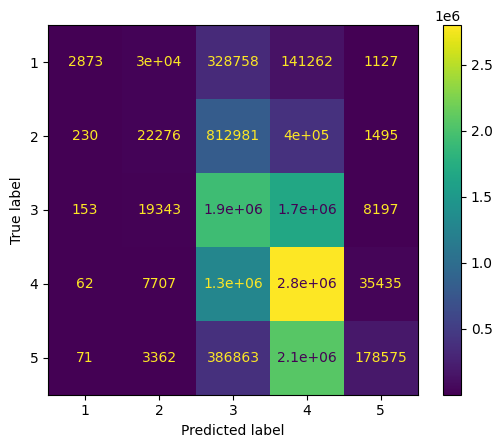

In [92]:
cm = confusion_matrix(y_true=true_rating_train_nmf, y_pred=pred_rating_train_int_nmf)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=[1,2,3,4,5])
cm_display.plot()
plt.show()

On training dataset, it's already biased towards 3 and 4 score.

#### Testing dataset performance

In [94]:
# testing RMSE
true_rating_test_nmf = rating_test["Rating"]
zipped_input_pairs_nmf = np.stack((rating_test["User_ID"], rating_test["Movie_ID"]), axis=-1)
pred_rating_test_nmf = np.array([get_rating_pred(ratings_pred, user_id, movie_id) for user_id, movie_id in zipped_input_pairs_nmf])

rmse_test_nmf = rmse(np.array(true_rating_test_nmf), np.array(pred_rating_test_nmf))
rmse_test_nmf

0.9563742891517981

As we can see, by matrix decomposition, the training (0.944) and testing (0.956) dataset shows roughly the same RMSE accuracy value. Then our model may not be overfitting.

In [95]:
# confusion matrix
# note: confusion matrix can only handle categorical data, so I need to convert float number to int.

pred_rating_test_nmf_int = np.vectorize(round)(pred_rating_test_nmf)
print(np.unique(pred_rating_test_nmf_int, return_counts=True))

(array([1, 2, 3, 4, 5, 6]), array([   1474,   35427, 2029436, 3042004,   92746,     151]))


In [96]:
# we see the model predicted some movies to 6-star!
# need to convert 6 to 5
pred_rating_test_nmf_int = np.vectorize(lambda x: 5 if x>5 else x)(pred_rating_test_nmf_int)
print(np.unique(pred_rating_test_nmf_int, return_counts=True))

(array([1, 2, 3, 4, 5]), array([   1474,   35427, 2029436, 3042004,   92897]))


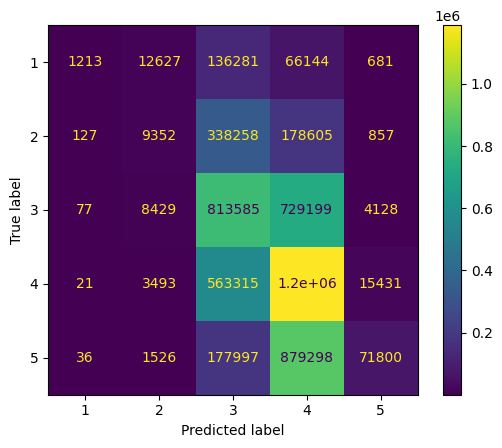

In [97]:
cm = confusion_matrix(y_true=true_rating_test_nmf, y_pred=pred_rating_test_nmf_int)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=[1,2,3,4,5])
cm_display.plot()
plt.show()

Similar pattern as the training set: the prediction is biased towards 3-4 score.

### 2.2.2 hyper parameter tune - n_components

We already know there are 5 ratings, and n_components=5 seems to be appropriate. However, there are still chances that the ratings may be better clustered into more or less groups. For example, 
- Some people may essentially have 3 groups in their mind: good, fair, bad, which may cause n_components to be lower.
- Some movies might have the same rating (eg: 4), but there are subtle difference between them (like 3.6 vs. 4.4), which may cause n_components to be higher.

Therefore, it's worthwhile to try different n_components to see. 
- The higher n_components, the more likely we may overfit.

In [152]:
COMP_CNT = [3,4,5,6,7]
training_rmse_nmf = []
testing_rmse_nmf = []

def get_rmse_nmf(raw_df, ratings_pred):
    true_rating = raw_df["Rating"]
    zipped_input = np.stack((raw_df["User_ID"], raw_df["Movie_ID"]), axis=-1)
    pred_rating = np.array([get_rating_pred(ratings_pred, user_id, movie_id) for user_id, movie_id in zipped_input])
    rmse_train_nmf = rmse(np.array(true_rating), np.array(pred_rating))
    return rmse_train_nmf

for comp in COMP_CNT:
    
    # nndsvda is Nonnegative Double Singular Value Decomposition, which is good for dense matrix
    # ratings_imputed is dense matrix, because all 0 values are filled with user_means
    it_nmf = NMF(n_components=comp, init='nndsvda', random_state=42) 
    it_W = it_nmf.fit_transform(ratings_imputed)  # User-feature matrix
    it_H = it_nmf.components_  # Item-feature matrix
    it_ratings_pred = np.dot(it_W, it_H)
    it_train_rmse_nmf = get_rmse_nmf(rating_train, it_ratings_pred)
    it_test_rmse_nmf = get_rmse_nmf(rating_test, it_ratings_pred)
    print(f"For n_components={comp}, train RMSE = {it_train_rmse_nmf}, test RMSE = {it_test_rmse_nmf}")
    training_rmse_nmf.append(it_train_rmse_nmf)
    testing_rmse_nmf.append(it_test_rmse_nmf)
    

For n_components=3, train RMSE = 0.942447962653393, test RMSE = 0.9538767752972768
For n_components=4, train RMSE = 0.9433269798412702, test RMSE = 0.9550336716910026
For n_components=5, train RMSE = 0.944341181255052, test RMSE = 0.9563742891517981
For n_components=6, train RMSE = 0.9451518343574083, test RMSE = 0.9575785989979858
For n_components=7, train RMSE = 0.9457890193147956, test RMSE = 0.958319250632245


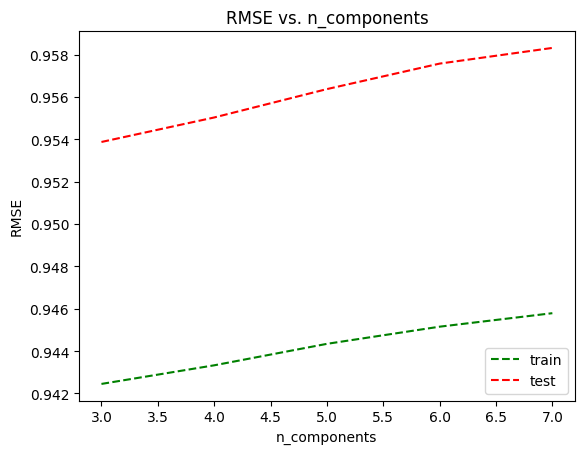

In [154]:
fig, ax = plt.subplots()

ax.plot(COMP_CNT, training_rmse_nmf, 'g--', label='train')
ax.plot(COMP_CNT, testing_rmse_nmf, 'r--', label='test')
ax.set_xlabel('n_components')
ax.set_ylabel('RMSE')
ax.set_title('RMSE vs. n_components')

leg = ax.legend(loc="lower right")
plt.show()

I have a few observations:
- n_components as a hyper parameter, it doesn't have huge effect. Changing from 3 to 7, may only cause 0.004 difference (0.942 -> 0.946)
- In general, the higher n_components, the higher RMSE. Then we'd better maintain a low n_components if possible.
  - The reason why `n_components=3` works best, may be because in the `ratings vs year` graph above:
    - 50% of the ratings, are highly concentrated between 3.0-4.0
    - 90% of the ratings, are concentrated between 2.5 - 4.5
    - Therefore, although the scale is 1-5, the effective range is actually smaller.

## 3. Model comparison 

I used 2 different models as above. Both of them are unsupervised learning.
- Collaborative filtering
- Matrix decomposition

To make an apple to apple comparison, let's compare their base model (with 20% rating removal). 
Collaborative filtering:
- rmse_train=0.4259265147052411
- rmse_test=0.9727047801887826

Matrix decomposition:
- rmse_train = 0.944341181255052
- rmse_test = 0.9563742891517981

As shown above, collaborative filtering performs much better in training set, but slightly worse in test set, compared to decomposition.

### Analysis:
- Typically if a model performs better in training but worse in testing, it's an indicator of overfitting.
- Is collaborative filtering overfitting compared to decomposition?
  - Likely yes.
  - The reason is that, the features in collaborative filtering, are similarity matrix, which has size of 1350x1350 = 1.82M. However, the features in matrix decomposition, are user latent preferences (with size of 87799 users x 5 n_components) + movie latent characteristics (with size of 1350 movies x 5 n_components) = 0.45M.
  - Then we can see, matrix decomposition has 0.45M params, which is only 25% of collaborative filtering.

## 4. Conclusion

### What I did

In this project, I used 2 different unsupervised learning algos: Collaborative filtering, and Matrix decomposition. 

I did some EDA to visualize features like rating and publish year distribution, and investigate the relationship between those 2 features.

Then I applied data cleaning to remove some less important rating data (20% user rating data), and visualized user deleted vs rating deleted.

Then I apply those 2 models above, get the accuracy and confusion matrix for both training and testing dataset. Then I tuned hyper parameters for each of them: number of ratings deleted in collaborative filtering, and n_components in NMF.

Then I compared the performance between those 2, and identified the core reason for the difference is due to overfitting.

### What I can do in future

Those 2 models above are both unsupervised models. I would like to try supervised one like K-means in the future.